In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

In [2]:
torch.__version__

'1.13.1+cu117'

In [3]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda') # nvidia gpu
    elif torch.backends.mps.is_available():
        return torch.device('mps') # apple silicon gpu
    else:
        return torch.device('cpu') # default
    
device = get_default_device()
device

device(type='cuda')

In [69]:
actions = ['매도', '홀드', '매수']
# 데이터 로드 및 전처리
df = pd.read_csv('../data/preprocessed/drop_IBM.csv')
data = df['Close'].values

# train, test 데이터 분리 (7:3 비율)
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

seq_len = 7

X_train, y_train = [], []
for i in range(len(train_data) - seq_len):
    X_train.append(train_data[i:i + seq_len])
    y_train.append(train_data[i + seq_len])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(len(test_data) - seq_len):
    X_test.append(test_data[i:i + seq_len])
    y_test.append(test_data[i + seq_len])
X_test, y_test = np.array(X_test), np.array(y_test)

class StockTradingEnv:
    def __init__(self, data, init_capital=10000, transaction_cost=0.001):
        self.data = np.array(data)
        self.init_capital = init_capital
        self.transaction_cost = transaction_cost
        self.reset()

    def reset(self):
        self.t = 0
        self.capital = self.init_capital
        self.shares = 0
        self.state = self.data[:seq_len].tolist()
        return self.state

    def step(self, action):
        price = self.data[self.t + seq_len]
        
        if action == 0:  # 매도
            if self.shares > 0:
                self.capital += self.shares * price * (1 - self.transaction_cost)
                self.shares = 0
            else:
                action = 1  # 주식이 없으면 홀드로 전환

        elif action == 2:  # 매수
            shares_to_buy = int(self.capital / price)
            if shares_to_buy > 0:
                self.shares += shares_to_buy
                self.capital -= shares_to_buy * price * (1 + self.transaction_cost)
            else:
                action = 1  # 살 수 있는 주식이 없으면 홀드로 전환

        self.t += 1
        done = self.t >= len(self.data) - seq_len
        next_state = self.data[self.t:self.t + seq_len].tolist()
        reward = (self.capital + self.shares * price - self.init_capital) / 10000
        info = {}

        return next_state, reward, done, info



# 초기화 및 테스트
env = StockTradingEnv(data)
state = env.reset()
print(f"Initial state: {state}")

# 예시 단계 실행
next_state, reward, done, info = env.step(2)
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}, Info: {info}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1]  # 최종 hidden state를 가져옵니다.
        action_probs = self.fc(h_n)
        action_probs = nn.functional.softmax(action_probs, dim=-1)
        return action_probs

class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ValueNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h_n = h_n[-1]  # 최종 hidden state를 가져옵니다.
        value = self.fc(h_n)
        return value

class ActorCriticAgent:
    def __init__(self, input_size, hidden_size, output_size, batch_size):
        self.policy_net = PolicyNetwork(input_size, hidden_size, output_size).to(device)
        self.value_net = ValueNetwork(input_size, hidden_size).to(device)
        self.policy_optimizer = optim.AdamW(self.policy_net.parameters())
        self.value_optimizer = optim.AdamW(self.value_net.parameters())
        self.batch_size = batch_size

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action_probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float32).to(device)
        actions = torch.tensor(transition_dict['actions']).to(device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float32).to(device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float32).to(device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float32).to(device)

        dataset_size = len(states)
        for start_idx in range(0, dataset_size, self.batch_size):
            end_idx = min(start_idx + self.batch_size, dataset_size)
            batch_states = states[start_idx:end_idx]
            batch_actions = actions[start_idx:end_idx]
            batch_rewards = rewards[start_idx:end_idx]
            batch_next_states = next_states[start_idx:end_idx]
            batch_dones = dones[start_idx:end_idx]

            values = self.value_net(batch_states).squeeze(-1)
            next_values = self.value_net(batch_next_states).squeeze(-1)
            expected_values = batch_rewards + (1 - batch_dones) * 0.99 * next_values.detach()
            value_loss = torch.mean((values - expected_values) ** 2)

            self.value_optimizer.zero_grad()
            value_loss.backward(retain_graph=True)
            self.value_optimizer.step()

            action_probs = self.policy_net(batch_states)
            action_dist = torch.distributions.Categorical(action_probs)
            log_probs = action_dist.log_prob(batch_actions)
            advantages = (expected_values - values).detach()
            policy_loss = -torch.mean(log_probs * advantages)

            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            self.policy_optimizer.step()

# 에이전트 초기화
input_size = seq_len
hidden_size = 256
output_size = 3
batch_size = 128
agent = ActorCriticAgent(input_size, hidden_size, output_size, batch_size)

# 예시 상태
state = env.reset()
action = agent.get_action(state)
print(f"Selected action: {actions[action]}")

# 예시 업데이트
transition_dict = {
    'states': [state] * batch_size,
    'actions': [action] * batch_size,
    'rewards': [1.0] * batch_size,
    'next_states': [state] * batch_size,
    'dones': [0] * batch_size
}
agent.update(transition_dict)
print("Update complete")


Initial state: [77.026772, 78.059273, 79.913956, 82.217972, 80.487572, 83.173996, 83.824089, 83.661568, 84.684509, 83.738052, 82.265778, 77.724663, 76.998085, 76.19503, 77.485657, 75.516251, 74.971321, 76.586998, 76.787766, 74.856598, 74.760994]
Next state: [78.059273, 79.913956, 82.217972, 80.487572, 83.173996, 83.824089, 83.661568, 84.684509, 83.738052, 82.265778, 77.724663, 76.998085, 76.19503, 77.485657, 75.516251, 74.971321, 76.586998, 76.787766, 74.856598, 74.760994, 74.741875], Reward: -0.0009940669374998833, Done: False, Info: {}
Selected action: 매수
Update complete


Episode 1/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 821.32it/s]


Episode 1/100, Total Reward: -1065.07, Total Capital: 5474.59


Episode 2/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 845.15it/s]


Episode 2/100, Total Reward: 2751.27, Total Capital: 20082.50


Episode 3/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 897.75it/s]


Episode 3/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 4/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 827.96it/s]


Episode 4/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 5/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 825.00it/s]


Episode 5/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 6/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 878.69it/s]


Episode 6/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 7/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 893.04it/s]


Episode 7/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 8/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 878.17it/s]


Episode 8/100, Total Reward: 2670.09, Total Capital: 19635.94


Episode 9/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 882.08it/s]


Episode 9/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 10/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 870.26it/s]


Episode 10/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 11/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 871.25it/s]


Episode 11/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 12/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 812.65it/s]


Episode 12/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 13/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 783.71it/s]


Episode 13/100, Total Reward: 2694.84, Total Capital: 19859.57


Episode 14/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 873.89it/s]


Episode 14/100, Total Reward: 2624.77, Total Capital: 19314.13


Episode 15/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 865.39it/s]


Episode 15/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 16/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 890.84it/s]


Episode 16/100, Total Reward: 2654.99, Total Capital: 19497.46


Episode 17/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 875.14it/s]


Episode 17/100, Total Reward: 2644.47, Total Capital: 19360.00


Episode 18/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 869.30it/s]


Episode 18/100, Total Reward: 2668.53, Total Capital: 19643.20


Episode 19/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 843.86it/s]


Episode 19/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 20/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 716.57it/s]


Episode 20/100, Total Reward: 2639.03, Total Capital: 19490.57


Episode 21/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 727.84it/s]


Episode 21/100, Total Reward: 2726.85, Total Capital: 19825.43


Episode 22/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 849.47it/s]


Episode 22/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 23/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 880.98it/s]


Episode 23/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 24/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 899.08it/s]


Episode 24/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 25/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 903.37it/s]


Episode 25/100, Total Reward: 2666.67, Total Capital: 19591.87


Episode 26/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 907.16it/s] 


Episode 26/100, Total Reward: 2722.34, Total Capital: 20172.83


Episode 27/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 913.54it/s]


Episode 27/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 28/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 894.29it/s]


Episode 28/100, Total Reward: 2645.40, Total Capital: 19295.08


Episode 29/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 732.24it/s]


Episode 29/100, Total Reward: 2685.72, Total Capital: 19627.40


Episode 30/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 694.37it/s]


Episode 30/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 31/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 762.47it/s]


Episode 31/100, Total Reward: 2598.08, Total Capital: 19147.04


Episode 32/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 827.87it/s]


Episode 32/100, Total Reward: 2601.72, Total Capital: 19184.43


Episode 33/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 904.15it/s]


Episode 33/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 34/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 919.15it/s] 


Episode 34/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 35/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 878.76it/s]


Episode 35/100, Total Reward: 2671.56, Total Capital: 19560.30


Episode 36/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 813.85it/s]


Episode 36/100, Total Reward: 2608.55, Total Capital: 19385.94


Episode 37/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 860.19it/s]


Episode 37/100, Total Reward: 2690.38, Total Capital: 19656.05


Episode 38/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 885.24it/s]


Episode 38/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 39/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 867.51it/s]


Episode 39/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 40/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 844.45it/s]


Episode 40/100, Total Reward: 2761.74, Total Capital: 19951.21


Episode 41/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 727.11it/s]


Episode 41/100, Total Reward: 2612.35, Total Capital: 19392.84


Episode 42/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 783.13it/s]


Episode 42/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 43/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 708.54it/s]


Episode 43/100, Total Reward: 2510.24, Total Capital: 19085.53


Episode 44/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 826.96it/s]


Episode 44/100, Total Reward: 2636.40, Total Capital: 19319.15


Episode 45/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 862.29it/s]


Episode 45/100, Total Reward: 2643.07, Total Capital: 19240.05


Episode 46/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 846.67it/s]


Episode 46/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 47/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 869.75it/s]


Episode 47/100, Total Reward: 2580.64, Total Capital: 19213.49


Episode 48/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 853.26it/s]


Episode 48/100, Total Reward: 2612.47, Total Capital: 19283.10


Episode 49/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 834.20it/s]


Episode 49/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 50/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 804.70it/s]


Episode 50/100, Total Reward: 2654.14, Total Capital: 19515.22


Episode 51/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 849.40it/s]


Episode 51/100, Total Reward: 2684.77, Total Capital: 19663.75


Episode 52/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 774.92it/s]


Episode 52/100, Total Reward: 2661.19, Total Capital: 19722.44


Episode 53/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 861.86it/s]


Episode 53/100, Total Reward: 2568.87, Total Capital: 19147.69


Episode 54/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 766.66it/s]


Episode 54/100, Total Reward: 2633.23, Total Capital: 19266.06


Episode 55/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 770.00it/s]


Episode 55/100, Total Reward: 2616.74, Total Capital: 19333.41


Episode 56/100: 100%|█████████▉| 3746/3747 [00:06<00:00, 577.78it/s]


Episode 56/100, Total Reward: 2887.42, Total Capital: 20652.87


Episode 57/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 704.07it/s]


Episode 57/100, Total Reward: 2795.62, Total Capital: 20327.48


Episode 58/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 771.22it/s]


Episode 58/100, Total Reward: 2891.18, Total Capital: 21089.89


Episode 59/100: 100%|█████████▉| 3746/3747 [00:06<00:00, 606.66it/s]


Episode 59/100, Total Reward: 2616.26, Total Capital: 19156.53


Episode 60/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 693.04it/s]


Episode 60/100, Total Reward: 2504.90, Total Capital: 19244.54


Episode 61/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 670.30it/s]


Episode 61/100, Total Reward: 2524.27, Total Capital: 18748.65


Episode 62/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 733.86it/s]


Episode 62/100, Total Reward: 2706.57, Total Capital: 19521.46


Episode 63/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 863.75it/s]


Episode 63/100, Total Reward: 2185.67, Total Capital: 15831.49


Episode 64/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 810.70it/s]


Episode 64/100, Total Reward: 1563.18, Total Capital: 14468.52


Episode 65/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 829.76it/s]


Episode 65/100, Total Reward: 2546.75, Total Capital: 18233.08


Episode 66/100: 100%|█████████▉| 3746/3747 [00:06<00:00, 622.67it/s]


Episode 66/100, Total Reward: 1275.29, Total Capital: 12304.26


Episode 67/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 771.69it/s]


Episode 67/100, Total Reward: -0.78, Total Capital: 7926.23


Episode 68/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 802.66it/s]


Episode 68/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 69/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 820.48it/s]


Episode 69/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 70/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 682.43it/s]


Episode 70/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 71/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 814.66it/s]


Episode 71/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 72/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 842.85it/s]


Episode 72/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 73/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 817.79it/s]


Episode 73/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 74/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 836.16it/s]


Episode 74/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 75/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 843.73it/s]


Episode 75/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 76/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 806.29it/s]


Episode 76/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 77/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 849.29it/s]


Episode 77/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 78/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 793.40it/s]


Episode 78/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 79/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 862.26it/s]


Episode 79/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 80/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 877.66it/s]


Episode 80/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 81/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 772.32it/s]


Episode 81/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 82/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 716.67it/s]


Episode 82/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 83/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 790.88it/s]


Episode 83/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 84/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 833.71it/s]


Episode 84/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 85/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 713.37it/s]


Episode 85/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 86/100: 100%|█████████▉| 3746/3747 [00:05<00:00, 710.52it/s]


Episode 86/100, Total Reward: 2657.52, Total Capital: 19545.46


Episode 87/100: 100%|█████████▉| 3746/3747 [00:04<00:00, 807.65it/s]


Episode 87/100, Total Reward: 2657.52, Total Capital: 19545.46
Early stopping triggered at episode 87
Training complete
Action counts: [1735, 1140, 323114]


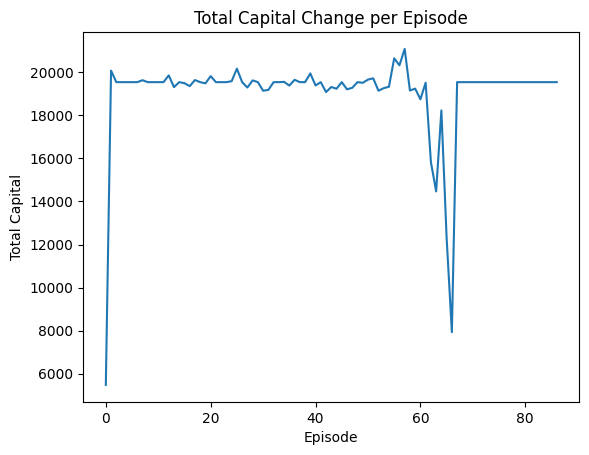

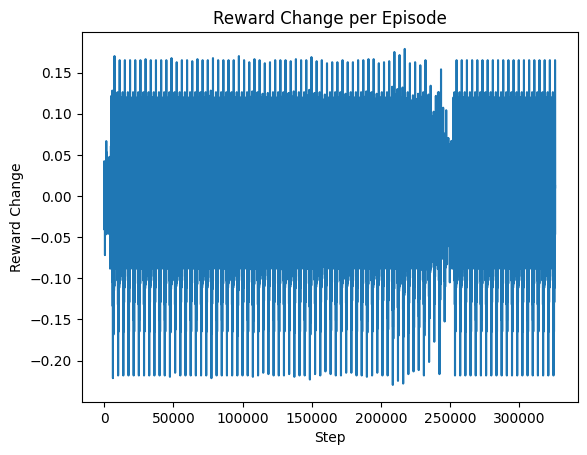

매도: 1735
홀드: 1140
매수: 323114


In [70]:
# 학습 루프
env = StockTradingEnv(train_data)

num_episodes = 100
max_steps = len(env.data) - seq_len  # 최대 스텝 수 설정
checkpoint_freq = 10  # 체크포인트 저장 빈도
early_stopping_patience = 20  # 얼리 스탑핑 기준 에피소드 수

action_counts = [0, 0, 0]  # 각 행동의 선택 횟수 카운트
episode_capital = []  # 각 에피소드에서의 자본금 기록
episode_rewards_change = []  # 각 에피소드에서의 보상 변동량 기록

# 체크포인트 저장 디렉토리 생성
checkpoint_dir = '../checkpoints/ibm1'
os.makedirs(checkpoint_dir, exist_ok=True)

# 얼리 스탑핑 변수 초기화
previous_capitals = []

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    transitions = {
        'states': [],
        'actions': [],
        'rewards': [],
        'next_states': [],
        'dones': []
    }
    
    for step in tqdm(range(max_steps), desc=f"Episode {episode + 1}/{num_episodes}"):
        action = agent.get_action(state)
        action_counts[action] += 1  # 각 행동의 선택 횟수 증가
        next_state, reward, done, _ = env.step(action)
        
        transitions['states'].append(state)
        transitions['actions'].append(action)
        transitions['rewards'].append(reward)
        transitions['next_states'].append(next_state)
        transitions['dones'].append(done)
        
        state = next_state
        episode_reward += reward
        
        if done:
            current_total_capital = env.capital + env.shares * env.data[env.t + seq_len - 1]
            episode_capital.append(current_total_capital)  # 에피소드 종료 시 총 자본금 기록
            
            # 에피소드에서의 보상 변동량 기록
            rewards_change = [transitions['rewards'][i] - transitions['rewards'][i-1] 
                              for i in range(1, len(transitions['rewards']))]
            episode_rewards_change.extend(rewards_change)
            
            break
    
    # 에이전트 업데이트
    agent.update(transitions)
    
    # 체크포인트 저장
    if (episode + 1) % checkpoint_freq == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_episode_{episode + 1}.pt")
        torch.save(agent.policy_net.state_dict(), checkpoint_path)
    
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {episode_reward:.2f}, Total Capital: {current_total_capital:.2f}")
    
    # 얼리 스탑핑 조건 검사
    previous_capitals.append(current_total_capital)
    if len(previous_capitals) > early_stopping_patience:
        previous_capitals.pop(0)
    
    if len(previous_capitals) == early_stopping_patience and len(set(previous_capitals)) == 1:
        print(f"Early stopping triggered at episode {episode + 1}")
        break

print("Training complete")
print("Action counts:", action_counts)

# 에피소드별 자본금 변동 시각화
plt.plot(episode_capital)
plt.xlabel('Episode')
plt.ylabel('Total Capital')
plt.title('Total Capital Change per Episode')
plt.show()

# 에피소드별 보상 변동량 시각화
plt.plot(episode_rewards_change)
plt.xlabel('Step')
plt.ylabel('Reward Change')
plt.title('Reward Change per Episode')
plt.show()

for i, count in enumerate(action_counts):
    print(f"{actions[i]}: {count}")


In [72]:
print("max: ",max(episode_capital[:num_episodes]))
print("min: ",min(episode_capital[:num_episodes]))

max:  21089.893116488016
min:  5474.592844676462


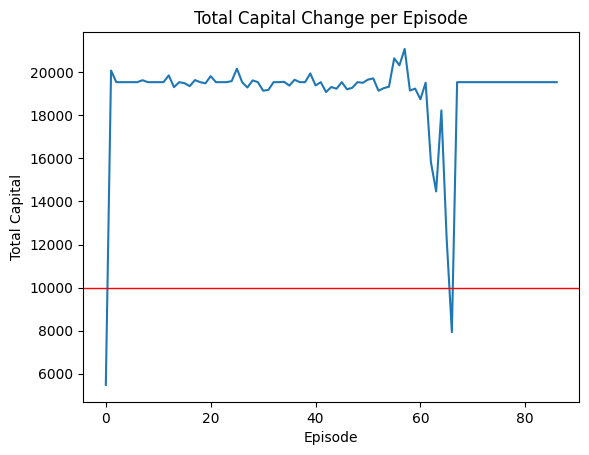

In [71]:
# 에피소드별 자본금 변동 시각화
plt.plot(episode_capital)
plt.xlabel('Episode')
plt.ylabel('Total Capital')
plt.axhline(y=10000, color='r', linewidth=1)
plt.title('Total Capital Change per Episode')
plt.show()

Testing checkpoint_episode_10.pt: 100%|█████████▉| 1594/1595 [00:01<00:00, 898.91it/s]


Test Total Reward: -217.30
Total reward from testing: -217.30


Testing checkpoint_episode_20.pt: 100%|█████████▉| 1594/1595 [00:01<00:00, 874.37it/s]


Test Total Reward: -224.98
Total reward from testing: -224.98


Testing checkpoint_episode_30.pt: 100%|█████████▉| 1594/1595 [00:01<00:00, 970.99it/s] 


Test Total Reward: -217.30
Total reward from testing: -217.30


Testing checkpoint_episode_40.pt: 100%|█████████▉| 1594/1595 [00:01<00:00, 852.71it/s]


Test Total Reward: -217.30
Total reward from testing: -217.30


Testing checkpoint_episode_50.pt: 100%|█████████▉| 1594/1595 [00:01<00:00, 852.48it/s]


Test Total Reward: -203.26
Total reward from testing: -203.26


Testing checkpoint_episode_60.pt: 100%|█████████▉| 1594/1595 [00:02<00:00, 793.81it/s]


Test Total Reward: -233.46
Total reward from testing: -233.46


Testing checkpoint_episode_70.pt: 100%|█████████▉| 1594/1595 [00:01<00:00, 986.77it/s] 


Test Total Reward: -217.30
Total reward from testing: -217.30


Testing checkpoint_episode_80.pt: 100%|█████████▉| 1594/1595 [00:01<00:00, 808.52it/s]


Test Total Reward: -217.30
Total reward from testing: -217.30


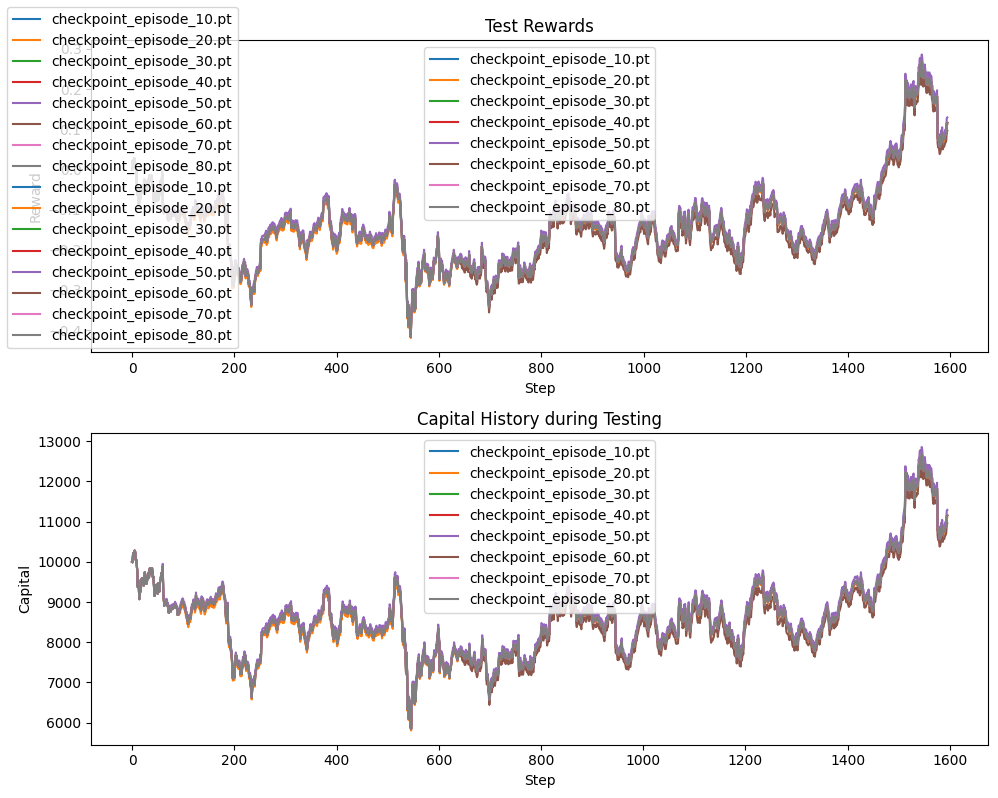

In [78]:
# 체크포인트마다 테스트
checkpoint_dir = '../checkpoints/ibm1'
checkpoint_files = sorted(os.listdir(checkpoint_dir))

fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 2개의 서브플롯 생성

for i, checkpoint_file in enumerate(checkpoint_files):
    if checkpoint_file.endswith(".pt"):
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)

        # 체크포인트 불러오기
        agent.policy_net.load_state_dict(torch.load(checkpoint_path))

        # 테스트 환경 초기화
        # test_env = StockTradingEnv(test_data)
        test_env = StockTradingEnv(test_data)
        state = test_env.reset()
        test_episode_reward = 0
        test_transitions = {
            'states': [],
            'actions': [],
            'rewards': [],
            'next_states': [],
            'dones': []
        }
        capital_history = [test_env.init_capital]
        test_actions = []

        # 테스트 진행
        for step in tqdm(range(len(test_env.data) - seq_len), desc=f"Testing {checkpoint_file}"):
            action = agent.get_action(state)
            test_actions.append(action)
            next_state, reward, done, _ = test_env.step(action)

            test_transitions['states'].append(state)
            test_transitions['actions'].append(action)
            test_transitions['rewards'].append(reward)
            test_transitions['next_states'].append(next_state)
            test_transitions['dones'].append(done)

            state = next_state
            test_episode_reward += reward
            capital_history.append(test_env.capital + test_env.shares * test_env.data[test_env.t + seq_len - 1])

            if done:
                break

        print(f"Test Total Reward: {test_episode_reward:.2f}")

        # 테스트 데이터에서의 성능을 로깅하기 위해 추가된 부분
        test_rewards = test_transitions['rewards']
        test_total_reward = sum(test_rewards)
        print(f"Total reward from testing: {test_total_reward:.2f}")

        # 테스트 데이터에서의 보상 시각화
        axes[0].plot(test_rewards, label=checkpoint_file)  # 첫 번째 서브플롯에 그래프 추가
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Reward')
        axes[0].set_title('Test Rewards')

        # 캐피탈 변동 기록 및 시각화
        axes[1].plot(capital_history, label=checkpoint_file)  # 두 번째 서브플롯에 그래프 추가
        axes[1].set_xlabel('Step')
        axes[1].set_ylabel('Capital')
        axes[1].set_title('Capital History during Testing')

# 모든 그래프에 범례 추가
axes[0].legend()
axes[1].legend()
fig.legend(loc="upper left")

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

Testing Progress: 100%|█████████▉| 1594/1595 [00:01<00:00, 1002.11it/s]


Test Total Reward: -217.30
Actions during testing: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

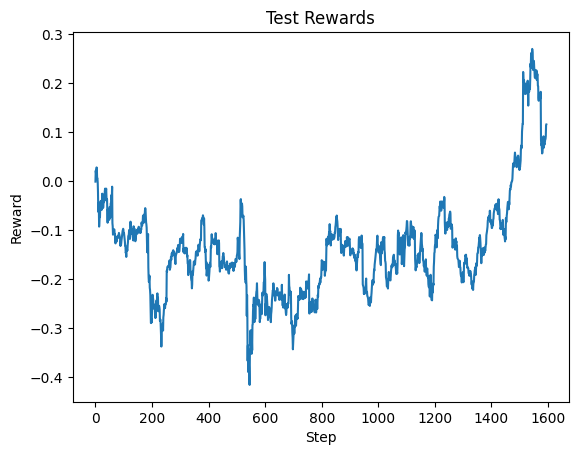

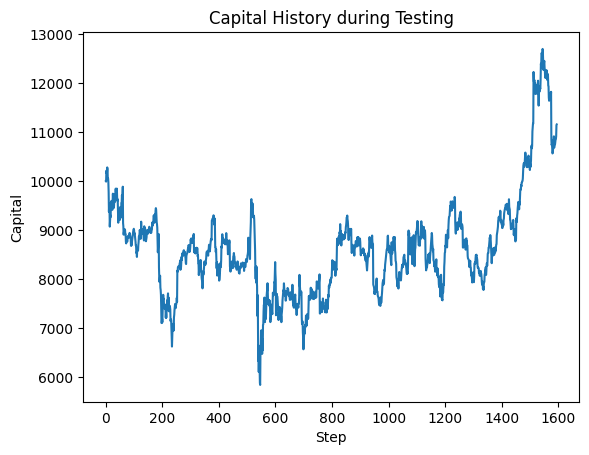

매도: 0
홀드: 0
매수: 1595


In [79]:
test_env = StockTradingEnv(test_data)
action_counts = [0, 0, 0]  # 각 행동의 선택 횟수 카운트
state = test_env.reset()
test_episode_reward = 0
test_transitions = {
    'states': [],
    'actions': [],
    'rewards': [],
    'next_states': [],
    'dones': []
}
capital_history = [test_env.init_capital]
test_actions = []  # 테스트 중 수행한 액션을 기록하기 위한 리스트

# agent.policy_net.load_state_dict(torch.load(r'..\checkpoints\ibm1\checkpoint_episode_50.pt'))



for step in tqdm(range(len(test_env.data) - seq_len), desc="Testing Progress"):
    action = agent.get_action(state)
    test_actions.append(action)  # 수행한 액션 기록
    next_state, reward, done, _ = test_env.step(action)
    
    test_transitions['states'].append(state)
    test_transitions['actions'].append(action)
    test_transitions['rewards'].append(reward)
    test_transitions['next_states'].append(next_state)
    test_transitions['dones'].append(done)
    action_counts[action] += 1  # 각 행동의 선택 횟수 증가
    
    state = next_state
    test_episode_reward += reward
    capital_history.append(test_env.capital + test_env.shares * test_env.data[test_env.t + seq_len - 1])
    
    if done:
        break

print(f"Test Total Reward: {test_episode_reward:.2f}")

# 테스트 중 수행한 액션 출력
print("Actions during testing:", test_actions)

# 테스트 데이터에서의 성능을 로깅하기 위해 추가된 부분
test_rewards = test_transitions['rewards']
test_total_reward = sum(test_rewards)
print(f"Total reward from testing: {test_total_reward:.2f}")

# 테스트 데이터에서의 보상 시각화
plt.plot(test_rewards)
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Test Rewards')
plt.show()

# 캐피탈 변동 기록 및 시각화
plt.plot(capital_history)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.title('Capital History during Testing')
plt.show()

for i, count in enumerate(action_counts):
    print(f"{actions[i]}: {count}")


In [80]:
print(capital_history[-1])
print(max(capital_history))

11157.454507135999
12699.214315136


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score

# 테스트 데이터에서의 예측 가격 계산
predicted_prices = np.array(capital_history)[:-1] / test_env.init_capital  # 마지막 행 삭제

# MAE 계산
mae = mean_absolute_error(test_data[seq_len:], predicted_prices)

# RMSLE 계산
rmsle = np.sqrt(mean_squared_log_error(test_data[seq_len:], predicted_prices))

# R-squared 계산
r_squared = r2_score(test_data[seq_len:], predicted_prices)

print("MAE:", mae)
print("RMSLE:", rmsle)
print("R-squared:", r_squared)

# 결과 시각화
plt.figure(figsize=(12, 6))

# 예측 가격 시각화
plt.plot(predicted_prices, label='Predicted Prices', color='blue')

# 테스트 데이터의 실제 가격 시각화
plt.plot(test_data[seq_len:], label='Real Prices', color='orange')

plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.title('Predicted vs Real Prices')
plt.legend()
plt.show()




ValueError: Found input variables with inconsistent numbers of samples: [1056, 5363]

NameError: name 'mae' is not defined

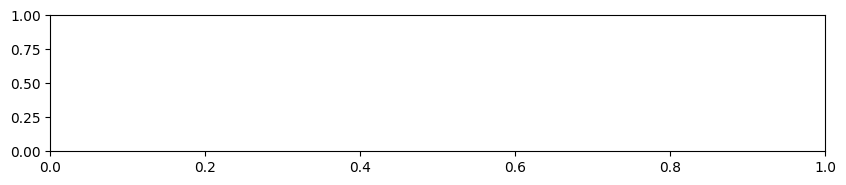

In [12]:
# MAE, RMSLE, R-squared 시각화
plt.figure(figsize=(10, 6))

# MAE 시각화
plt.subplot(3, 1, 1)
plt.plot([mae] * len(predicted_prices), linestyle='--', label='MAE', color='green')
plt.xlabel('Time Step')
plt.ylabel('MAE')
plt.title('MAE, RMSLE, R-squared')
plt.legend()

# RMSLE 시각화
plt.subplot(3, 1, 2)
plt.plot([rmsle] * len(predicted_prices), linestyle='--', label='RMSLE', color='blue')
plt.xlabel('Time Step')
plt.ylabel('RMSLE')
plt.legend()

# R-squared 시각화
plt.subplot(3, 1, 3)
plt.plot([r_squared] * len(predicted_prices), linestyle='--', label='R-squared', color='red')
plt.xlabel('Time Step')
plt.ylabel('R-squared')
plt.legend()

plt.tight_layout()
plt.show()
